In [1]:
import numpy as np 
import h5py
import scipy.io
import matplotlib.pyplot as plt 
from mat73 import loadmat 

In [2]:
f = h5py.File('D:/PulseDB/Segment_Files/PulseDB_MIMIC/p000160.mat','r')
print(f.keys())
refs = f.get('#refs#')
print(refs.keys())
subj = f.get('Subj_Wins')
print(subj.keys())
print("PPG: ", subj['PPG_Raw'].shape, len(subj['PPG_Raw'][0]))

# for name, var in subj.items():
#     print(name, var.shape)

<KeysViewHDF5 ['#refs#', 'Subj_Wins']>
<KeysViewHDF5 ['0', '0A', '0B', '0C', '0D', '0b', '0c', '0d', '0e', '0f', '0g', '0h', '0i', '0j', '0k', '0l', '0m', '0n', '0o', '0p', '0q', '0r', '0s', '0t', '0u', '0v', '0w', '0x', '0y', '0z', '1', '1A', '1B', '1C', '1D', '1b', '1c', '1d', '1e', '1f', '1g', '1h', '1i', '1j', '1k', '1l', '1m', '1n', '1o', '1p', '1q', '1r', '1s', '1t', '1u', '1v', '1w', '1x', '1y', '1z', '2', '2A', '2B', '2C', '2D', '2b', '2c', '2d', '2e', '2f', '2g', '2h', '2i', '2j', '2k', '2l', '2m', '2n', '2o', '2p', '2q', '2r', '2s', '2t', '2u', '2v', '2w', '2x', '2y', '2z', '3', '3A', '3B', '3C', '3D', '3b', '3c', '3d', '3e', '3f', '3g', '3h', '3i', '3j', '3k', '3l', '3m', '3n', '3o', '3p', '3q', '3r', '3s', '3t', '3u', '3v', '3w', '3x', '3y', '3z', '4', '4A', '4B', '4C', '4D', '4b', '4c', '4d', '4e', '4f', '4g', '4h', '4i', '4j', '4k', '4l', '4m', '4n', '4o', '4p', '4q', '4r', '4s', '4t', '4u', '4v', '4w', '4x', '4y', '4z', '5', '5A', '5B', '5C', '5D', '5b', '5c', '5d', '5e'

In [3]:
data = loadmat('D:/PulseDB/Segment_Files/PulseDB_MIMIC/p000160.mat')['Subj_Wins']
print(data.keys())
print(data['SubjectID'][0])
ppg = data['PPG_F']
abp = data['ABP_Raw']
print(len(ppg), len(ppg[0]), len(ppg[0][0]))

dict_keys(['ABP_F', 'ABP_Lag', 'ABP_Raw', 'ABP_SPeaks', 'ABP_Turns', 'Age', 'CaseID', 'ECG_F', 'ECG_RPeaks', 'ECG_Raw', 'Gender', 'IncludeFlag', 'PPG_ABP_Corr', 'PPG_F', 'PPG_Raw', 'PPG_SPeaks', 'PPG_Turns', 'SegDBP', 'SegSBP', 'SegmentID', 'SubjectID', 'WinID', 'WinSeqID'])
['p000160']
82 1 1250


# Train subset

- 10s segments of 125 Hz
- PPG is one specific type of BVP measurement. 

In [4]:
def Build_Dataset(Path,FieldName='Subset'):
        Data=loadmat(Path)
        # Access 10-s segments of ECG, PPG and ABP signals
        Signals=Data[FieldName]['Signals']
        # Access SBP labels of each 10-s segment
        SBPLabels=Data[FieldName]['SBP']
        # Access Age of the subject corresponding to each of the 10-s segment
        Age=Data[FieldName]['Age']
        # Access Gender of the subject corresponding to each of the 10-s segment
        Gender=np.array(Data[FieldName]['Gender']).squeeze()
        # Convert Gender to numerical 0-1 labels
        Gender=(Gender=='M').astype(float)
        # Access Height and Weight of the subject corresponding to each of the 10-s segment
        # If the subject is from the MIMIC-III matched subset, height and weight will be NaN 
        # since they were only recorded in VitalDB
        Height=Data[FieldName]['Height']
        Weight=Data[FieldName]['Weight']
        # Concatenate the demographic information as one matrix
        Demographics=np.stack((Age,Gender,Height,Weight),axis=1)
        return Data,Signals,SBPLabels,Demographics
        
Data,Signals,SBPLabels,Demographics = Build_Dataset('D:/PulseDB/Subset_Files/Train_Subset.mat')

In [ ]:
print(Data.keys(), Data['Subset'].keys())
print("Demographics: ", Demographics.shape, "(age, gender, height, weight)")
print("True labal:", SBPLabels.shape, "Data: ",Data['Subset']['Signals'].shape, len(Data['Subset']['Subject']))
# 902160 segments, 10s each, 125Hz sampling rate

# find unique subject IDs
subjects = np.array(Data['Subset']['Subject']).squeeze()
subject_ids = np.unique(list(filter(None, subjects)))
print("Number of different subjects :", subject_ids.size, subject_ids[0])

# find segments corresponding to a particular subject
indices = dict()
for subject in subject_ids:
    indices[subject] = [index for index, value in enumerate(Data['Subset']['Subject']) if value[0] == subject]

# get segments for a particular subject
idx = 0
subject = Data['Subset']['Subject'][idx][0]
segment_indices = indices[subject] # get index of segment in indices
print(subject, len(segment_indices))
signal = Signals[segment_indices]
label = SBPLabels[segment_indices]
print("Data and true label shape: (125 Hz * 10s = 1250 samples, 360 windows, 3 signals ECG,PPG,ABP)", signal.shape, label.shape)

dict_keys(['Subset']) dict_keys(['Age', 'BMI', 'DBP', 'Gender', 'Height', 'SBP', 'Signals', 'Subject', 'Weight'])
Demographics:  (902160, 4) (age, gender, height, weight)
True labal: (902160,) Data:  (902160, 3, 1250) 902160
Number of different subjects : 290 p000001_1
p000001_1 0 360
Data and true label shape: (125 Hz * 10s = 1250 samples, 360 windows, 3 signals ECG,PPG,ABP) (360, 3, 1250) (360,)


Age: 48.0, Gender: 1.0, Height: 177.4 cm, Weight: 65.0 kg


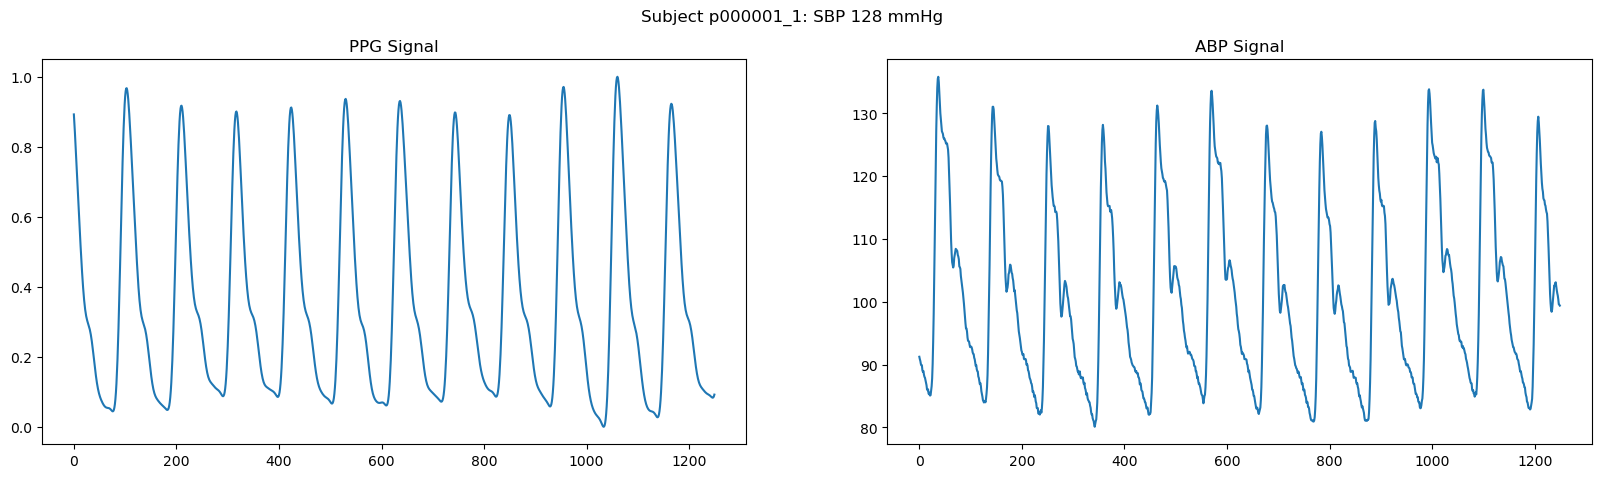

In [ ]:
subject_index = 0
signal_index = 291
index = indices[subject_ids[subject_index]][signal_index]

ECG, PPG, ABP = 0,1,2
Age, Gender, Height, Weight = 0,1,2,3
subject = subjects[subject_index]
# gender: 1 is Male
print(f"Age: {Demographics[index][Age]}, Gender: {Demographics[index][Gender]}, Height: {Demographics[index][Height]} cm, Weight: {Demographics[index][Weight]} kg")

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(Signals[index][PPG])
axs[0].set_title("PPG Signal")
axs[1].plot(Signals[index][ABP])
axs[1].set_title("ABP Signal")
plt.suptitle(f"Subject {subject_ids[subject_index]}: SBP {int(SBPLabels[index])} mmHg")
plt.show()

In [ ]:
train_size = 3
test_size = 1
trainData = []
testData = []
trainLabel = []
testLabel = []
trainDemographics = []
testDemographics = []

for subject in subject_ids[:train_size+test_size]:
    segment_indices = indices[subject]
    for i in range(len(segment_indices)):
        index = segment_indices[i]
        if i < train_size:
            trainData.append(Signals[index])
            trainLabel.append(SBPLabels[index])
            trainDemographics.append(Demographics[index])
        else:
            testData.append(Signals[index])
            testLabel.append(SBPLabels[index])
            testDemographics.append(Demographics[index])

# Make small subset of data 
for key in Data.keys():
    if isinstance(Data[key], dict):
        for k in Data[key].keys():
            print(k, len(Data[key][k]))
            if isinstance(Data[key][k], np.ndarray):
                print("ndarray")
                if Data[key][k].shape[0] == 1:
                    Data[key][k] = Data[key][k][0]
                else:
                    Data[key][k] = Data[key][k].squeeze()
            else:
                print("not ndarray")
    else:
        print("not dict")

Age 902160
ndarray
BMI 902160
ndarray
DBP 902160
ndarray
Gender 902160
not ndarray
Height 902160
ndarray
SBP 902160
ndarray
Signals 902160
ndarray
Subject 902160
not ndarray
Weight 902160
ndarray


# Model

In [ ]:
# TCN model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# this is also copilot
class PulseDataset(Dataset):
    def __init__(self, Data, Signals, SBPLabels, Demographics, indices=None):
        self.Data = Data
        self.Signals = Signals
        self.SBPLabels = SBPLabels
        self.Demographics = Demographics

        self.subject_ids = np.unique(list(filter(None, np.array(Data['Subset']['Subject']).squeeze())))
        
        # find segments corresponding to a particular subject
        if indices is None:
            indices = dict()
            for subject in subject_ids:
                indices[subject] = [index for index, value in enumerate(Data['Subset']['Subject']) if value[0] == subject]
        self.indices = indices

    def __len__(self):
        return len(self.Data['Subset']['Signals'])
        # return len(self.subject_ids)

    # # Get all segments for a particular subject
    # def __getitem__(self, idx):
    #     # get subject ID
    #     subject = self.Data['Subset']['Subject'][idx][0]
    #     # get index of segment in indices
    #     segment_indices = self.indices[subject]
    #     # get demographics # one is enough
    #     demographics = self.Demographics[segment_indices[0]]
    #     # get signal # 3d array (360, 3, 1250) ECG PPG ABP
    #     signal = self.Signals[segment_indices]
    #     # get label # 1d array
    #     label = self.SBPLabels[segment_indices]
    #     return signal, label, demographics

    def __getitem__(self, idx):
        # get subject ID
        subject = self.Data['Subset']['Subject'][idx][0]
        # get index of subject ID in subject_ids
        subject_index = np.where(self.subject_ids == subject)[0][0]
        # get index of segment in indices
        segment_index = self.indices[subject][subject_index]
        # get signal
        signal = self.Signals[segment_index]
        # get label
        label = self.SBPLabels[segment_index]
        # get demographics
        demographics = self.Demographics[segment_index]
        return signal, label, demographics
    
    # idk
    def collate_fn(self, batch):
        signals = []
        labels = []
        demographics = []
        for signal, label, demographic in batch:
            signals.append(signal)
            labels.append(label)
            demographics.append(demographic)
        signals = torch.tensor(signals, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        demographics = torch.tensor(demographics, dtype=torch.float32)
        return signals, labels, demographics

In [8]:
import torch
import torch.nn as nn

# chatgpt
class TemporalBlock(nn.Module):
    def __init__(self, input_size, output_size, kernel_size, stride, dilation, padding):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(input_size, output_size, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)

        self.conv2 = nn.Conv1d(output_size, output_size, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(input_size, output_size, 1) if input_size != output_size else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, padding=(kernel_size-1) * dilation_size)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TCN(nn.Module):
    def __init__(self, input_size, num_channels, output_size, kernel_size=2):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size)
        self.fc = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        y = self.tcn(x)
        y = y[:, :, -1]
        y = self.fc(y)
        return y


In [10]:
# Example usage:
input_size = 10  # Adjust based on your input features
num_channels = [64, 64, 64]  # Adjust based on your model complexity
output_size = 3  # Number of classes (normotensive, hypertensive, hypotensive)

model = TCN(input_size, num_channels, output_size)

# Generate toy input data
batch_size = 32
sequence_length = 50
toy_input = torch.randn(batch_size, input_size, sequence_length)

# Forward pass
output = model(toy_input)

# Print the output
print("Toy Input Shape:", toy_input.shape)
print("Model Output Shape:", output.shape)
print("Model Output:")
print(output)

Toy Input Shape: torch.Size([32, 10, 50])
Model Output Shape: torch.Size([32, 3])
Model Output:
tensor([[ 1.0640e-01,  1.9574e-01,  2.7633e-01],
        [-5.2564e-02, -1.7403e-01,  3.5771e-01],
        [ 6.0677e-01,  2.6547e-01,  1.3417e-01],
        [ 3.8102e-04,  2.5344e-01,  5.4433e-01],
        [ 3.1404e-01, -3.3236e-02,  6.7114e-02],
        [ 2.8633e-01, -2.3900e-01, -1.3955e-01],
        [ 5.6906e-01,  5.6933e-01,  6.6510e-02],
        [-1.5419e-01,  3.6370e-01,  2.6807e-01],
        [ 5.4587e-01,  3.7283e-01,  7.3029e-02],
        [ 2.7277e-01, -1.1179e-01,  6.4114e-02],
        [ 1.6940e-01,  3.5190e-01,  1.6551e-01],
        [ 2.0868e-01,  2.2234e-01,  3.1737e-01],
        [ 5.2217e-02,  2.7084e-01,  4.3259e-01],
        [ 4.3668e-02, -4.2969e-01,  1.7941e-02],
        [ 4.6937e-01,  3.7531e-01,  8.6459e-01],
        [ 2.3714e-01,  1.3630e-01,  3.1667e-01],
        [-8.1254e-02,  2.5920e-01, -5.9672e-02],
        [ 3.5499e-01, -2.1037e-01,  4.0439e-02],
        [ 3.2140e-01, 

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)



In [ ]:
# TCN model from copilot

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = nn.Sequential(
            nn.Conv1d(input_size, num_channels, kernel_size, dropout=dropout),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(num_channels, num_channels, kernel_size, dropout=dropout),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(num_channels, num_channels, kernel_size, dropout=dropout),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(num_channels, num_channels, kernel_size, dropout=dropout),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(num_channels, num_channels, kernel_size, dropout=dropout),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(num_channels, num_channels, kernel_size, dropout=dropout),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(num_channels, num_channels, kernel_size, dropout=dropout),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear(num_channels, output_size)
        )
    
    def forward(self, x):
        return self.tcn(x)
    
    def predict(self, x):
        return self.forward(x).argmax(dim=1)
    
    def predict_proba(self, x):
        return F.softmax(self.forward(x), dim=1)
    
    

# Info

In [7]:
info = loadmat('D:/PulseDB/Info_Files/Train_Info.mat')

KeyboardInterrupt: 

In [ ]:
print(info.keys())
print(info['Train_Subset'].keys())
print(len(info['Train_Subset']['Subj_Name']))
print(info['Train_Subset']['Subj_Name'][0], info['Train_Subset']['Subj_SegIDX'][0])
print(info['Train_Subset']['Subj_Age'][0], info['Train_Subset']['Subj_BMI'][0], info['Train_Subset']['Subj_Gender'][0], info['Train_Subset']['Subj_Height'][0], info['Train_Subset']['Subj_Weight'][0])
print(info['Train_Subset']['Source'][0]) 
print(info['Train_Subset']['Seg_SBP'][0])


dict_keys(['Train_Subset'])
dict_keys(['Seg_DBP', 'Seg_SBP', 'Source', 'Subj_Age', 'Subj_BMI', 'Subj_Gender', 'Subj_Height', 'Subj_Name', 'Subj_SegIDX', 'Subj_Weight'])
902160
['p000188_0'] [array(2833.)]
[array(57.)] [array(nan)] ['M'] [array(nan)] [array(nan)]
['MIMIC']
[array(100.24998388)]


In [ ]:
indices = [index for index, value in enumerate(info['Train_Subset']['Subj_Name']) if value[0] == 'p000188_0']
print(len(indices))

360
